# 全体実装

## 入力状態作成

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time 

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.tools.visualization import plot_histogram
import json
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import math
import matplotlib.ticker as tick

In [3]:
import sys
sys.path.append('../../src')

In [ ]:
# 初期配置(0は空欄に対応)
mat = \
    np.array([[1, 3, 0, 0],
              [0, 0, 3, 1],
              [0, 4, 1, 0],
              [3, 0, 0, 4]])

# 正答
correct_mat = \
    np.array([[1, 3, 4, 2],
              [4, 2, 3, 1],
              [2, 4, 1, 3],
              [3, 1, 2, 4]])

Sudoku matrix to solve


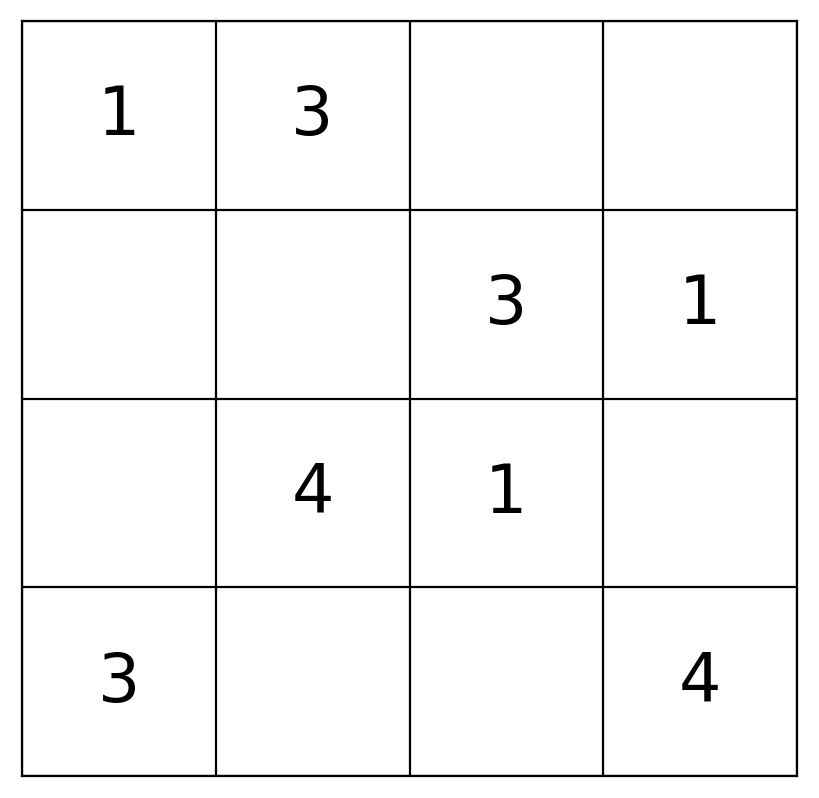

In [5]:
#draws sudoku template
#0 represents an empty cell
#negative value represents an incorrect answer
def draw_matrix(template, template_answer_filled, wrong_indices):
    #compute size of sudoku matrix
    rows = template.shape[0]
    columns = template.shape[1]
    #create vector from sudoku matrix
    flat = template.reshape(1, rows**2)[0]
    #based on the indices of the vector, create a list of empty cell indices
    empty_indices = np.array([np.array([k//4,k%4]) for k in range(rows*columns) if flat[k] == 0])
    #create empty sudoku matrix plot
    fig, ax = plt.subplots(facecolor="w", figsize = (5, 5), dpi = 200)
    #change tick location to match the lines of sudoku matrices
    fig.gca().xaxis.set_major_locator(tick.MultipleLocator(1))
    fig.gca().yaxis.set_major_locator(tick.MultipleLocator(1))
    ax.grid(which='major',color='black',linestyle='-')
    #eliminate ticks
    ax.tick_params(direction = "in", length = 0, colors = "black")
    plt.xlim(0,4)
    plt.ylim(0,4)
    #eliminate ticks
    plt.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
    #fill in the corresponding numbers
    for index in [[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]:
        if template_answer_filled[index[0]][index[1]] == 0:
            pass
        elif index in wrong_indices:
            ax.text(index[1] + 0.5, 3 - index[0]+0.5, str(template_answer_filled[index[0]][index[1]]), {'color': 'red', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
        else:
            ax.text(index[1] + 0.5, 3 - index[0]+0.5, str(template[index[0]][index[1]]), {'color': 'black', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
    plt.show()
    
print('Sudoku matrix to solve')
draw_matrix(mat, mat, [])

#Determines the values in the box in which the cell is contained
def determine_box(template, row, column):
    if row <= 1 and column <= 1:
        box = np.array([template[i[0]][i[1]] for i in [[0,0],[0,1],[1,0],[1,1]]])
        #if the empty cell belongs to the upper right box
    elif row <= 1 and column > 1:
        box = np.array([template[i[0]][i[1]] for i in [[0,2],[0,3],[1,2],[1,3]]])
        #if the empty cell belongs to the lower left box
    elif row > 1 and column <= 1:
        box = np.array([template[i[0]][i[1]] for i in [[2,0],[2,1],[3,0],[3,1]]])
        #if the empty cell belongs to the lower right box
    elif row > 1 and column > 1:
        box =  np.array([template[i[0]][i[1]] for i in [[2,2],[2,3],[3,2],[3,3]]])
    return box

#fill in the blanks
def fill(template, sequence):
    #the number of rows of the sudoku matrix
    rows = template_answer_filled.shape[0]
    #the number of columns of the sudoku matrix
    columns = template_answer_filled.shape[1]
    #sudoku matrix converted into a vector
    flat = template.reshape(1, rows**2)[0]
    #array containing the indices of the empty cells of the initial sudoku matrix
    empty_rows = np.array([k//4 for k in range(rows*columns) if flat[k] == 0])
    empty_cols = np.array([k%4 for k in range(rows*columns) if flat[k] == 0])
    #fill in
    for i, j, k in zip(empty_rows,empty_cols, range(len(sequence))):
        template[i][j] = sequence[k]
    return template

# sequence = [3,1,2,3,2,3,3,1]
# print(fill(mat, sequence))

#checks that a given sudoku matrix has the correct sum for each row, column and box.
#returns the template
def check(template, template_answer_filled):
    #the number of rows of the sudoku matrix
    rows = template_answer_filled.shape[0]
    #the number of columns of the sudoku matrix
    columns = template_answer_filled.shape[1]
    #the correct sum of each row, column or box
    correct_sum = np.sum([k for k in range(1, rows+1)])
    #sudoku matrix converted into a vector
    flat = template.reshape(1, rows**2)[0]
    #array containing the indices of the empty cells of the initial sudoku matrix
    empty_rows = np.array([k//4 for k in range(rows*columns) if flat[k] == 0])
    empty_cols = np.array([k%4 for k in range(rows*columns) if flat[k] == 0])
    #list to be filled with indices of cells containing wrong answers
    wrong_indices = []
    #checks each element in terms of the sum of the row, column and box.
    for i, j in zip(empty_rows, empty_cols):
        row = np.sum(template_answer_filled[i][:])
        column = np.sum([template_answer_filled[k][j] for k in range(rows)])
        box = np.sum(determine_box(template_answer_filled, i, j))
        if row == correct_sum and column == correct_sum and box == correct_sum:
            pass
        else:
            wrong_indices.append([i,j])
    return wrong_indices

# wrong_indices = check(template, template_answer_filled)
# print(wrong_indices)

# draw_matrix(template, template_answer_filled, wrong_indices)

## 初期状態作成

In [6]:
#Input: sudoku matrix, output: list of qubit numbers assigned to each empty cell and
#the list of numbers in the same row, column and qubicle of each empty cell
def nums(mat):
    rows = mat.shape[0]
    columns = mat.shape[1]
    flat = mat.reshape(1, rows**2)[0]
    empty_indices = np.array([np.array([k//4,k%4]) for k in range(rows*columns) if flat[k] == 0])
    q_nums = np.array([[k, k+1] for k in range(0, len(empty_indices)*2, 2)])
    num = []
    for k,index in zip(range(len(empty_indices)),empty_indices):
        row = mat[index[0]][:]
        column = np.array([mat[k][index[1]] for k in range(rows)])
        #if the empty cell belongs to the upper left box
        if index[0] <= 1 and index[1] <= 1:
            box = np.array([mat[i[0]][i[1]] for i in [[0,0],[0,1],[1,0],[1,1]]])
        #if the empty cell belongs to the upper right box
        elif index[0] <= 1 and index[1] > 1:
            box = np.array([mat[i[0]][i[1]] for i in [[0,2],[0,3],[1,2],[1,3]]])
        #if the empty cell belongs to the lower left box
        elif index[0] > 1 and index[1] <= 1:
            box = np.array([mat[i[0]][i[1]] for i in [[2,0],[2,1],[3,0],[3,1]]])
        #if the empty cell belongs to the lower right box
        elif index[0] > 1 and index[1] > 1:
            box =  np.array([mat[i[0]][i[1]] for i in [[2,2],[2,3],[3,2],[3,3]]])
        num.append(np.array([row, column, box]).reshape(1, 12)[0])
    return empty_indices, np.array(num)

print(nums(mat))

(array([[0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [2, 0],
       [2, 3],
       [3, 1],
       [3, 2]]), array([[1, 3, 0, 0, 0, 3, 1, 0, 0, 0, 3, 1],
       [1, 3, 0, 0, 0, 1, 0, 4, 0, 0, 3, 1],
       [0, 0, 3, 1, 1, 0, 0, 3, 1, 3, 0, 0],
       [0, 0, 3, 1, 3, 0, 4, 0, 1, 3, 0, 0],
       [0, 4, 1, 0, 1, 0, 0, 3, 0, 4, 3, 0],
       [0, 4, 1, 0, 0, 1, 0, 4, 1, 0, 0, 4],
       [3, 0, 0, 4, 3, 0, 4, 0, 0, 4, 3, 0],
       [3, 0, 0, 4, 0, 3, 1, 0, 1, 0, 0, 4]]))


In [7]:
#Input: sudoku matrix,
#Output: list of elements in the same row, column and box of the empty cell in question.
def candidates(mat, nums):
    sudoku_size = mat.shape[0]
    all_cands = np.arange(1, sudoku_size + 1)
    counts = np.array([np.count_nonzero(nums == all_cands[k]) for k in range(len(all_cands))])
    cand_indices = np.where(counts==0)[0]
    cands = np.array([all_cands[k] for k in cand_indices])
    return set(cands)

# print(candidates(mat, [4, 0, 2, 0, 0, 4, 0, 2, 2, 0, 0, 4]))

In [8]:
def single_cand_operation(qc, q0, q1, cands):
    if cands == {1}:
        pass
    elif cands == {2}:
        qc.x(q1)
    elif cands == {3}:
        qc.x(q0)
    else:
        qc.x(q0)
        qc.x(q1)
        
def single_cand_operation_inv(qc, q0, q1, cands): 
    '''identical as noinv'''
    if cands == {1}:
        pass
    elif cands == {2}:
        qc.x(q1)
    elif cands == {3}:
        qc.x(q0)
    else:
        qc.x(q1)
        qc.x(q0)

def two_cand_operation(qc, q0, q1, cands):
#     product = cands[0]*cands[1]
    #1 + 2
    if cands == {1, 2}:
        qc.h(q1)
    #1 + 3
    elif cands == {1, 3}:
        qc.h(q0)
    #1 + 4
    elif cands == {1, 4}:
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 3
    elif cands == {2, 3}:
        qc.x(q1)
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 4
    elif cands == {2, 4}:
        qc.x(q1)
        qc.h(q0)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)
    
def two_cand_operation_inv(qc, q0, q1, cands):
#     product = cands[0]*cands[1]
    #1 + 2
    if cands == {1, 2}:
        qc.h(q1)
    #1 + 3
    elif cands == {1, 3}:
        qc.h(q0)
    #1 + 4
    elif cands == {1, 4}:
        qc.cx(q0, q1)
        qc.h(q0)
    #2 + 3
    elif cands == {2, 3}:
        qc.cx(q0, q1)
        qc.h(q0)
        qc.x(q1)
    #2 + 4
    elif cands == {2, 4}:
        qc.h(q0)
        qc.x(q1)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)

In [9]:
def create_initial(qc, q, mat):
    # q: only qubits on blanks (ancillae not included)
#     draw_matrix(mat)
    empty_indices, num = nums(mat)
    cands_list = np.array([candidates(mat, num[k]) for k in range(len(num))])
    for j,k in zip(range(0, len(empty_indices)*2, 2),range(len(cands_list))):
        cands = cands_list[k]
        if len(cands) == 1:
            single_cand_operation(qc, q[j], q[j+1], cands)
        else:
            two_cand_operation(qc, q[j], q[j+1], cands)
            
def create_initial_inv(qc, q, mat):
    empty_indices, num = nums(mat)
    cands_list = np.array([candidates(mat, num[k]) for k in range(len(num))])
    for j,k in zip(range(0, len(empty_indices)*2, 2),range(len(cands_list))):
        cands = cands_list[k]
        if len(cands) == 1:
            single_cand_operation_inv(qc, q[j], q[j+1], cands)
        else:
            two_cand_operation_inv(qc, q[j], q[j+1], cands)

In [10]:
# oracle

# if v1 != v2 (number) then target = 1 else target = 0
def compare_vertex(qc, qr, v1, v2, target):
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])
    #
    qc.x(qr[target])

def compare_vertex_inv(qc, qr, v1, v2, target):
    qc.x(qr[target])
    #
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])

# とりあえず辺埋め込みオラクル
def simple_oracle(qc, qr):
    # vs = [0, 1, 2, 3, 4, 5, 6, 7]
    lst1 = [[0, 1], [2, 3], [4, 5], [6, 7], [2, 6], [0, 4]]
    lst2 = [[1, 5], [3, 7], [0, 2], [1, 3], [4, 6], [5, 7]]
    target = 16
    tmp1 = 30
    tmp2 = 31
    for elm in lst1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp1], qr[22:29], mode='basic')
    for elm in (reversed(lst1)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
        
    for elm in lst2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp2], qr[22:29], mode='basic')
    for elm in (reversed(lst2)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
    
    ##
    dst = 29
    qc.ccx(qr[tmp1], qr[tmp2], qr[dst])
    ##
    
    for elm in lst2:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp2], qr[22:29], mode='basic')
    for elm in (reversed(lst2)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)
        
    for elm in lst1:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    qc.mct(qr[16:target], qr[tmp1], qr[22:29], mode='basic')
    for elm in (reversed(lst1)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)



In [11]:
# diffusion
    
def diffusion(circuit, qr, mat):
    """
    diffusion (inversion about the mean) circuit.
    note that this implementation gives H^{\otimes n} (Id - |0..0><0...0|) H^{\otimes n}
    :param circuit:
    :param qr: QuantumRegister on nodes
    :return:
    """

    # circuit.h(qr)
    create_initial_inv(circuit, qr[:16], mat)  # 初期状態準備のユニタリ操作のinverse
    circuit.x(qr[:16])

    # apply multi-control CZ
    circuit.h(qr[15])
    # circuit.mct(qr[:-1], qr[-1], anc, mode='basic')
    circuit.mct(qr[:15], qr[15], qr[16:32], mode='basic')  # ancilla使うver
    circuit.h(qr[15])

    circuit.x(qr[:16])
    # circuit.h(qr)
    create_initial(circuit, qr[:16], mat)

In [12]:
# number of iteration
n_it = 1

def grover(circuit, q, c, mat):

    # set initial state
    create_initial(circuit, q[:16], mat)
    
    for _ in range(n_it):
        simple_oracle(circuit, q)
        diffusion(circuit, q, mat)
    
    circuit.barrier()
    
    # measurement
    circuit.measure(q[:n_cbits],c)

In [13]:
# circuit construction 
n_qubits = 32
n_blanks = 8
n_cbits = 2 * n_blanks

q = QuantumRegister(n_qubits) 
c = ClassicalRegister(n_cbits)
circuit = QuantumCircuit(q, c)

In [14]:
grover(circuit, q, c, mat)
print('circuit has been constructed!')

circuit has been constructed!


### Use Transpiler

回路の最適化により、計算が逆に遅くなったので断念

In [15]:
# from qiskit.compiler import transpile
# from qiskit.transpiler import PassManager

In [16]:
# https://qiskit.org/documentation/locale/ja/api/qiskit.compiler.transpile.html
# optimized_circuit = transpile(circuit, basis_gates=['u1', 'u3', 'u2', 'cx'], optimization_level=2) 

In [17]:
# circuit.draw(output='mpl')
# circuit.draw()
# optimized_circuit.draw()

## 実行

In [ ]:
### Execution
time0 = time.time()
# shots = 8000
shots = 1
print("shots:", shots)

## local simulator
# backend = Aer.get_backend('qasm_simulator')
## cloud simulator
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

job = execute(circuit, backend=backend, shots=shots, seed_simulator=12345)
# job = execute(optimized_circuit, backend=backend, shots=shots, seed_simulator=12345)  # to use transpiled circuit
# job = execute(circuit, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})

result = job.result()
count = result.get_counts()
time1 = time.time()
print(f"Calculations took {time1-time0} sec.")
print(count)

shots: 1


### データ処理

In [ ]:
# 10進数(1~4)に変換
def convert_to_decimal(str_bin):
    str_bin = ''.join(list(reversed(str_bin)))  # cbitに格納されるときに順番逆になっていることに注意
    list_dec = [str(int(str_bin[2*i:2*i+2], 2)+1) for i in range(len(str_bin)//2)]
    str_dec = ''.join(list_dec)
    return str_dec

In [ ]:
# histogram plot (decimal representation)
count_decimal = {}
for key, value in count.items():
    count_decimal[convert_to_decimal(key)] = value
plot_histogram(count_decimal)

In [101]:
# サンプリング結果の保存
import pickle
with open('count_another.pkl', 'wb') as pkl:
    pickle.dump(count_decimal , pkl)

### validation


In [ ]:
# サンプリング結果の最頻値
most_frequent = sorted(count.items(), key=lambda x:x[1], reverse=True)[0][0]
solution = convert_to_decimal(most_frequent)
print(solution)

In [ ]:
mat_answer_filled = mat.copy()

# 回答で埋める
k = 0
for i in range(4):
    for j in range(4):
        if mat_answer_filled[i][j] == 0:
            mat_answer_filled[i][j] = solution[k]
            k += 1
            
mat_answer_filled = np.array(mat_answer_filled)

In [ ]:
mat_answer_filled

In [ ]:
# 10進数のリスト
ans_10_list = mat_answer_filled.flatten().tolist()
print(ans_10_list)

In [ ]:
def row_judge(ans_10_list):
    for i in range(0, 16, 4):
        if len(list(set(ans_10_list[i:i+4]))) < 4:
            return False
    return True

def colum_judge(ans_10_list):
    for i in range(0,4):
        get_colum = []
        for j in range(i,16,4):
            get_colum.append(ans_10_list[j])
        if len(list(set(get_colum))) < 4:
            return False
        else:
            pass
    return True

def box_judge(ans_10_list):
    split_ans = []
    for i in range(0, len(ans_10_list), 2):
        split_ans.append([ans_10_list[i], ans_10_list[i+1]])
    for i in range(0, 2):
        get_box = split_ans[i] + split_ans[i+2]
        if len(list(set(get_box))) < 4:
            return False
        else:
            pass
    for i in range(4, 6):
        get_box = split_ans[i] + split_ans[i+2]
        if len(list(set(get_box))) < 4:
            return False
        else:
            pass
    return True

def judge_whole(ans_10_list):
  
    judgeA = row_judge(ans_10_list)
    judgeB = colum_judge(ans_10_list)
    judgeC = box_judge(ans_10_list)
    
    return(judgeA and judgeB and judgeC)

In [ ]:
judge_whole(ans_10_list)

In [ ]:
draw_matrix(mat, mat_answer_filled, [])